# Parte 6: Pruebas de similitud entre productos

* Importar el modelo de clasificacion
*  Descargar información de un producto que no se encuentre en la base de datos
* Estandarización de la información 
* Graficar sus datos
* Clasificar categoria y subcategoria 
* Importar dataframe que contiene features vectorizaciones 
* Encontrar sus productos similares 

In [290]:
import numpy as np
import pandas as pd
import os, glob,joblib,requests,regex,unidecode,io
import cv2
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil, sys
import urllib.request 
from wordcloud import WordCloud
import PIL
import tensorflow as tf
from pathlib import Path  
from PIL import Image
from io import BytesIO
import gower
from sklearn.cluster import KMeans
import requests
import requests
from IPython.display import Image, display

In [3]:
CWD = os.getcwd()

### Cargar modelos utilizado para extracción de características de los productos

In [4]:
filepath = Path(CWD+'/xception_model.pkl')  
xception_model = joblib.load(filepath)

2022-09-21 17:38:43.682806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
filepath = Path(CWD+'/svc_classifier_cat.pkl')  # CATEGORIA
svc_classifier_cat = joblib.load(filepath)

filepath = Path(CWD+'/svc_classifier_subcat.pkl')  # SUBCATEGORIA
svc_classifier_subcat = joblib.load(filepath)

In [6]:
filepath = Path(CWD+'/tfidf_vectorizer_cat.pkl')   # CATEGORIA
tfidf_vectorizer_cat = joblib.load(filepath)

filepath = Path(CWD+'/tfidf_vectorizer_subcat.pkl')   # CATEGORIA
tfidf_vectorizer_subcat = joblib.load(filepath)

#### Función de generación del id del grupo del producto 

In [ ]:
def create_label_group(df_filt): 
    x = list(df_filt['numeric_cat'])[0]
    y = list(df_filt['numeric_sub_cat'])[0]
    label_group = str(x) + str(y)
    return label_group

## Importar dataframe con características de otros productos

In [ ]:
filepath = Path(CWD+'/dataset_products_feats.csv')  
df_products_feats = pd.read_csv(filepath)
df_products_info.rename(columns={'categoria':'numeric_cat','subcategoria':'numeric_sub_cat'},inplace=True)
df_products_info['labelgroup']=[create_label_group(df_products_info.loc[[i]]) for i in range(len(df_products_info))]

# Productos de prueba

In [7]:
cats = requests.get('https://api.mercadolibre.com/sites/MLA/categories')
prod_categories= cats.json()

Se generará un ejemplo de la entrada de un producto "nuevo" y se evaluará el resultado de la similitud con otros productos

In [205]:
offsets = list(range(600,650,50))
results = []
cat_id = 'MLA5725' #accesorios para vehículos
for off in offsets:
    url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={off}'
    request = requests.get(url)
    data = request.json()
    results.append(data)

### Preprocesamiento 

In [206]:
def clean_name(text_name):
    text = text_name
    clean_text = regex.sub(r'\&[a-z]+\;', '', text)
    clean_text = regex.sub(r"\n", " ", text)
    clean_text = text.lower()
    clean_text = unidecode.unidecode(clean_text)
    clean_text = regex.sub(r'\s+', ' ', clean_text)
    clean_text = regex.sub('[^a-zA-Z]', ' ', clean_text).strip(' ')
    cleaned_df = clean_text
    return cleaned_df

In [ ]:
def display_multiple_img(urls):
    for url in urls:
        r = requests.get(url) 
        display(Image(r.content) )

In [207]:
nombre_prod = clean_name(results[0]['results'][0]['title'])
marca = clean_name(results[0]['results'][0]['attributes'][0]['value_name'])
img = results[0]['results'][0]['thumbnail']
price = results[0]['results'][0]['price']

In [208]:
df_test_prod = pd.DataFrame(list(zip([nombre_prod],[marca],[img],[price])),columns=['nombre_prod','marca','img','price'])

In [209]:
df_test_prod

,nombre_prod,marca,img,price
0,funda eco cuero ford ecosport mejor calidad ec...,dinamic,http://http2.mlstatic.com/D_837121-MLA50350555...,5889.05


El producto seleccionado aleatoriamente es una funda de cuero de automovil 

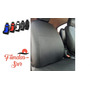

In [304]:
img_url = list(df_test_prod['img'])[0]
r = requests.get(img_url)
display(Image(r.content))

In [342]:
print(list(df_test_prod['nombre_prod']))

['funda eco cuero ford ecosport mejor calidad ecocuero modelos']


### Extraer vectores de los textos 

In [343]:
df_test_prod['name_vector'] = list(tfidf_vectorizer_cat.transform(df_test_prod['nombre_prod']).toarray())
df_test_prod['brand_vector'] = list(tfidf_vectorizer_cat.transform(df_test_prod['marca']).toarray())

### Vectorización de la imagen

In [211]:
urllib.request.urlretrieve(list(df_test_prod['img'])[0], "sample.png")

img = PIL.Image.open("sample.png")

In [212]:
image = img.resize((299,299))
image = np.expand_dims(image, axis=0)
image = image/127.5
image = image - 1.0
feature = xception_model.predict(image)

1/1 [==============================] - 1s 639ms/step


In [213]:
df_test_prod['image_feature'] = [feature[0]]

In [214]:
df_test_prod_feats = df_test_prod[['name_vector','brand_vector','price','image_feature']]

### Predecir clase y subclase

In [344]:
class_pred = svc_classifier_cat.predict(list(tfidf_vectorizer_cat.transform(df_test_prod['nombre_prod']).toarray()))[0]
print("CLASE: ",class_pred)

CLASE:  0


In [345]:
subclass_pred = svc_classifier_subcat.predict(list(tfidf_vectorizer_subcat.transform(df_test_prod['nombre_prod']).toarray()))[0]
print("SUBCLASE: ", subclass_pred)

SUBCLASE:  3


### Generar el id del grupo al que pertenece el producto

In [218]:
label_group = str(class_pred)+str(subclass_pred)
df_test_prod_feats['labelgroup'] = str(label_group)

/var/folders/_2/mn5plcvd0135m5y5pgyz6zpm0000gn/T/ipykernel_50607/3434840390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_prod_feats['labelgroup'] = str(label_group)


In [225]:
df_test_prod_feats

,name_vector,brand_vector,price,image_feature,labelgroup
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5889.05,"[0.16658403, 9.875476e-05, 0.0, 0.0, 0.0156745...",03


* El producto cuenta con las 5 características necesarias para comparar con los otros productos de la base de datos: vector de su nombre, vector de su marca, precio, vector de su imagen y id del gupo 

#### Cálculo del centroide de los vectores para su comparación 

In [226]:
df_test_prod_feats['centroid_name'] = [np.mean(n) for n in df_test_prod_feats['name_vector']]
df_test_prod_feats['centroid_brand'] = [np.mean(n) for n in df_test_prod_feats['brand_vector']]
df_test_prod_feats['centroid_image'] = [np.mean(n) for n in df_test_prod_feats['image_feature']]

/var/folders/_2/mn5plcvd0135m5y5pgyz6zpm0000gn/T/ipykernel_50607/3289489201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_prod_feats['centroid_name'] = [np.mean(n) for n in df_test_prod_feats['name_vector']]


## Filtro: 
* identificar los productos que hacen parte del mismo labelgroup

In [258]:
df_filt = df_products_info[df_products_info['labelgroup']==label_group]
df_filt.head()

,name,numeric_cat,numeric_sub_cat,name_vector,brand_vector,price,image_feature,labelgroup,url_imagen,centroid_name,centroid_brand,centroid_image
0,48 kit asientos auto cuero eco cubre volant...,0,3,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],13999.00,"[0.0792483389377594, 0.008941839449107647, 0.1...",03,http://http2.mlstatic.com/D_825151-MLA44504428...,0.000213,0.000000,0.111302
2,74 juego tazas rodado chevrolet agile ...,0,3,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],6059.99,"[0.25299349427223206, 0.1530793011188507, 9.23...",03,http://http2.mlstatic.com/D_617422-MLA47397731...,0.000257,0.000000,0.086682
5,60 traba volante antirrobo auto camioneta ...,0,3,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],2756.00,"[0.2211354672908783, 0.0, 0.06428234279155731,...",03,http://http2.mlstatic.com/D_922728-MLA48587720...,0.000230,0.000082,0.147074
59,61 cubre alfombra goma pesada universal p...,0,3,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],2589.99,"[0.1732514500617981, 0.5408852100372314, 0.0, ...",03,http://http2.mlstatic.com/D_957791-MLA48013661...,0.000292,0.000000,0.131293
61,75 juego x tazas rodado fiat uno fire ...,0,3,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],5579.99,"[0.08201831579208374, 0.004005333874374628, 0....",03,http://http2.mlstatic.com/D_829964-MLA49434325...,0.000255,0.000000,0.131210


In [242]:
df_test_prod_feats[['centroid_name','centroid_brand','price','centroid_image']]

,centroid_name,centroid_brand,price,centroid_image
0,0.000282,0.0,5889.05,0.098141


In [243]:
df_filt[['centroid_name','centroid_brand','price','centroid_image']]

,centroid_name,centroid_brand,price,centroid_image
0,0.000213,0.000000,13999.00,0.111302
1,0.000196,0.000000,17787.00,0.117811
2,0.000257,0.000000,6059.99,0.086682
3,0.000213,0.000000,13999.00,0.111302
4,0.000113,0.000000,1150.00,0.123773
...,...,...,...,...
19266,0.000163,0.000000,2590.00,0.079296
19267,0.000132,0.000139,3850.00,0.101924
19268,0.000164,0.000082,49000.00,0.117044
19269,0.000133,0.000000,43000.00,0.109853


Concatenar el resultado del producto nuevo y de los productos pertenecientes al mismo labelgroup, para encontrar sus similitudes

In [259]:
frames = [df_test_prod_feats[['centroid_name','centroid_brand','price','centroid_image']],df_filt[['centroid_name','centroid_brand','price','centroid_image']]]
result = pd.concat(frames)

# Gower's distance

#### Calcular la distancia entre el producto nuevo y los otros pertenecientes a su labelgroup

In [352]:
# max similarity 
gower_m_0 =gower.gower_matrix(result)[0]
gower_m_0

array([0.        , 0.16102794, 0.06184295, 0.490086  , 0.10724864,
       0.11587177, 0.41528347, 0.14572397, 0.08967274, 0.10465489,
       0.07707532, 0.04498137, 0.17977396, 0.56473285, 0.12143521,
       0.1878931 , 0.20976792, 0.2024333 , 0.45767716, 0.4084026 ,
       0.47137576, 0.43261376, 0.24011157, 0.11917765, 0.16466168,
       0.11585885, 0.09391698, 0.45116812, 0.5189458 , 0.38799027,
       0.16462511, 0.07828642, 0.40219164, 0.36215255, 0.08103844,
       0.51254934, 0.10431044, 0.09914795, 0.0524248 , 0.15397003,
       0.07685644, 0.22191267, 0.22608016, 0.4953556 , 0.13245638,
       0.04639006, 0.04594035, 0.00541423, 0.5442139 , 0.14973152,
       0.06334443], dtype=float32)

* Encontrar el producto con el cual existe una distancia mínima con el producto ingresaso, es decir con mayor similitud

In [359]:
min_dist = result[gower_m_0==min(gower_m_0[gower_m_0!= min(gower_m_0)])] #minimum distance
min_dist

,centroid_name,centroid_brand,price,centroid_image,clusters
1087,0.000281,0.0,6529.99,0.098893,0


In [363]:
ind_min = min_dist.index[0] #Conservar este índice para el posterior análisis

1087

* Encontrar el producto con el cual existe una distancia máxima con el producto ingresado, es decir con menor similitud

In [364]:
max_dist = result[gower_m_0==max(gower_m_0)] #max distance
max_dist

,centroid_name,centroid_brand,price,centroid_image,clusters
128,0.000181,0.000082,46596.0,0.123428,1


In [365]:
ind_max = max_dist.index[0] #Conservar este índice para el posterior análisis

#### Calcular las distancias entre todos los productos pertenecientes al labelgroup

In [261]:
gower_m_i =gower.gower_matrix(result)

#### Encontrar clusters para las distancias generadas

In [391]:
kmeans = KMeans(n_clusters=5).fit(np.array(gower_m_i))
centroids = kmeans.cluster_centers_
labels = kmeans.predict(np.array(gower_m_i))
result['clusters']=labels

In [396]:
result['clusters'].value_counts()

0    14
3    14
1    13
4     8
2     2
Name: clusters, dtype: int64

#### Extraer los índices de los clusters generados para evaluarlos

In [397]:
INDEX_0 = result[result['clusters'] == 0].index
INDEX_1 = result[result['clusters'] == 1].index
INDEX_2 = result[result['clusters'] == 2].index
INDEX_3 = result[result['clusters'] == 3].index
INDEX_4 = result[result['clusters'] == 4].index

In [335]:
df_products_out[df_products_out['index'].isin(INDEX_2)][['name','url_imagen']] 
list_url_2 = list(df_products_out[df_products_out['index'].isin(INDEX_2)]['url_imagen'])

#### Encontrar a cuál cluster pertenece el producto más similar:

In [398]:
print(ind_min in list(INDEX_0),ind_min in list(INDEX_1),ind_min in list(INDEX_2),ind_min in list(INDEX_3),ind_min in list(INDEX_4))

True False False False False


* El producto ingresado corresponde al Cluster 0: 

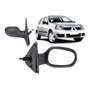

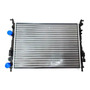

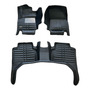

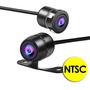

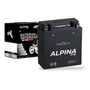

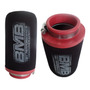

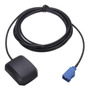

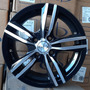

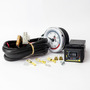

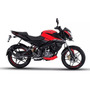

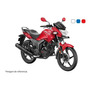

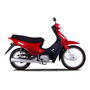

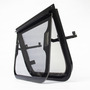

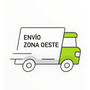

In [394]:
list_url_0 = list(df_products_out[df_products_out['index'].isin(INDEX_0)]['url_imagen'])
display_multiple_img(list_url_0)